<a href="https://colab.research.google.com/github/Kedhareswar799/hello-world/blob/main/stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter stock symbol (e.g., AAPL for Apple Inc.): AAPL
Enter prediction date (YYYY-MM-DD format): 2024-09-16


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 343ms/step - loss: 0.4051 - val_loss: 0.1049
Epoch 2/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - loss: 0.0638 - val_loss: 0.0130
Epoch 3/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - loss: 0.0227 - val_loss: 0.0099
Epoch 4/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - loss: 0.0081 - val_loss: 0.0091
Epoch 5/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - loss: 0.0092 - val_loss: 0.0029
Epoch 6/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 7/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 454ms/step - loss: 0.0047 - val_loss: 0.0012
Epoch 8/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 389ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 9/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 10/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 11/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 12/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - loss: 0.0017 - val_lo

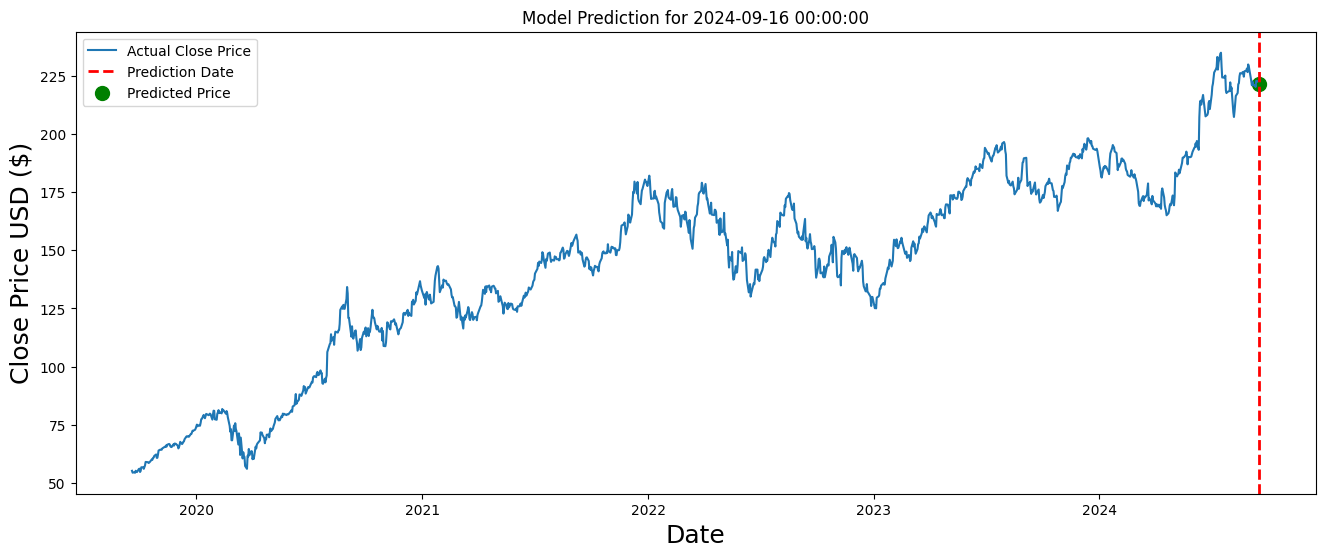

FileNotFoundError: [Errno 2] No such file or directory: 'price.xlsx'

In [2]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime  # Import datetime module
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
import yfinance as yf

# Removed yf.pdr_override() as it's no longer required

# Function to fetch data for given stock
def get_stock_data(stock, start, end):
    return yf.download(stock, start=start, end=end)['Close']

# Function to build LSTM model
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to prepare data for training
def prepare_data(stock_data):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(stock_data.values.reshape(-1, 1))
    x_train, y_train, x_test, y_test, training_data_len = [], [], [], [], int(len(scaled_data) * 0.67)
    for i in range(training_data_len, len(scaled_data)):
        x_train.append(scaled_data[i-60:i, 0])
        y_train.append(scaled_data[i, 0])
    for i in range(training_data_len, len(scaled_data) - 60):
        x_test.append(scaled_data[i-60:i, 0])
        y_test.append(scaled_data[i, 0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    return x_train, y_train, x_test, y_test, scaler, training_data_len

def main():
    # Manual input of stock name and prediction date
    stock_name = input("Enter stock symbol (e.g., AAPL for Apple Inc.): ")
    prediction_date_str = input("Enter prediction date (YYYY-MM-DD format): ")
    prediction_date = datetime.strptime(prediction_date_str, '%Y-%m-%d')

    # Fetch stock data
    end_date = prediction_date + pd.Timedelta(days=1)  # Add 1 day to include prediction date
    start_date = end_date - pd.Timedelta(days=365*5)  # Fetch data for the past 2 years
    stock_data = get_stock_data(stock_name, start_date, end_date)
    filename = f"{stock_name}_historical_data.csv"
    stock_data.to_csv(filename)
    # Prepare data for training
    x_train, y_train, x_test, y_test, scaler, training_data_len = prepare_data(stock_data)



    # Build and train LSTM model
    model = build_model((x_train.shape[1], 1))
    model.fit(x_train, y_train, batch_size=100, epochs=32, validation_data=(x_test, y_test))

    # Predict stock price for the given date
    scaled_data = scaler.transform(stock_data.values.reshape(-1, 1))
    predicted_price = predict_stock_price(model, scaled_data, scaler, training_data_len, prediction_date, stock_data)
    print("Predicted price for", prediction_date, "is:", predicted_price)
    # Plot actual vs predicted prices
    plot_predictions(stock_data, predicted_price, prediction_date)

# Function to predict stock price
def predict_stock_price(model, scaled_data, scaler, training_data_len, prediction_date, stock_data):
    test_data = scaled_data[training_data_len:, :]
    x_test = []
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    predicted_price = predictions[-1]
    return predicted_price

# Function to plot actual vs predicted prices
def plot_predictions(stock_data, predicted_price, prediction_date):
    plt.figure(figsize=(16, 6))
    plt.title('Model Prediction for {}'.format(prediction_date))
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(stock_data.index, stock_data.values, label='Actual Close Price')
    plt.axvline(x=prediction_date, color='r', linestyle='--', linewidth=2, label='Prediction Date')
    plt.scatter(prediction_date, predicted_price, color='g', s=100, label='Predicted Price')
    plt.legend(loc='upper left')
    plt.show()

# Function to plot actual vs predicted prices
def plot_predictions(stock_data, predicted_price, prediction_date):
    plt.figure(figsize=(16, 6))
    plt.title('Model Prediction for {}'.format(prediction_date))
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(stock_data.index, stock_data.values, label='Actual Close Price')
    plt.axvline(x=prediction_date, color='r', linestyle='--', linewidth=2, label='Prediction Date')
    plt.scatter(prediction_date, predicted_price, color='g', s=100, label='Predicted Price')
    plt.legend(loc='upper left')
    plt.show()

# Entry point of the program
if __name__ == "__main__":
    main()

!pip install pandas_datareader

import pandas as pd
from sklearn.metrics import mean_squared_error

# Load the actual and predicted prices from the Excel sheet
df = pd.read_excel('price.xlsx')

# Assuming the 'Actual' and 'Predicted' columns contain the actual and predicted prices respectively
actual_prices = df['Actual_price']
predicted_prices = df['Predicted Price']

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(actual_prices, predicted_prices)
print("Mean Squared Error (MSE):", mse)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)